In [93]:
# import the imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load the full csv with 15 years of data
pl_15years = pd.read_csv("../data/premier_league_omega.csv")
pl_15years['date'] = pd.to_datetime(pl_15years['date'], format="mixed")
pl_15years.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6141 entries, 0 to 6140
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   division              6140 non-null   object        
 1   date                  6140 non-null   datetime64[ns]
 2   home_team             6140 non-null   object        
 3   away_team             6140 non-null   object        
 4   full_time_home_goals  6140 non-null   float64       
 5   full_time_away_goals  6140 non-null   float64       
 6   full_time_result      6140 non-null   object        
 7   half_time_home_goals  6140 non-null   float64       
 8   half_time_away_goals  6140 non-null   float64       
 9   half_time_result      6140 non-null   object        
 10  referee               6140 non-null   object        
 11  home_shots            6140 non-null   float64       
 12  away_shots            6140 non-null   float64       
 13  home_shots_on_targ

In [70]:
def mega_league_table(df):
    table = pd.DataFrame()

    # Home stats
    home = df.groupby("home_team").agg(
        played_home=("home_team", "count"),
        wins_home=("full_time_result", lambda x: (x=="H").sum()),
        draws_home=("full_time_result", lambda x: (x=="D").sum()),
        losses_home=("full_time_result", lambda x: (x=="A").sum()),
        gf_home=("full_time_home_goals", "sum"),
        ga_home=("full_time_away_goals", "sum"),
        shots_home=("home_shots", "sum"),
        shots_on_target_home=("home_shots_on_target", "sum"),
        yellows_home=("home_yellow_cards", "sum"),
        reds_home=("home_red_cards", "sum")        
    )

    # Away stats
    away = df.groupby("away_team").agg(
        played_away=("away_team", "count"),
        wins_away=("full_time_result", lambda x: (x=="A").sum()),
        draws_away=("full_time_result", lambda x: (x=="D").sum()),
        losses_away=("full_time_result", lambda x: (x=="H").sum()),
        gf_away=("full_time_away_goals", "sum"),
        ga_away=("full_time_home_goals", "sum"),
        shots_away=("away_shots", "sum"),
        shots_on_target_away=("away_shots_on_target", "sum"),
        yellows_away=("away_yellow_cards", "sum"),
        reds_away=("away_red_cards", "sum")        
    )

    # Combine
    table = home.join(away, how="outer")
    table = table.fillna(0)

    table["played"] = table["played_home"] + table["played_away"]
    table["wins"] = table["wins_home"] + table["wins_away"]
    table["draws"] = table["draws_home"] + table["draws_away"]
    table["losses"] = table["losses_home"] + table["losses_away"]
    table["goals_for"] = table["gf_home"] + table["gf_away"]
    table["goals_against"] = table["ga_home"] + table["ga_away"]
    table["goal_difference"] = table["goals_for"] - table["goals_against"]
    table["points"] = table["wins"]*3 + table["draws"]
    table["total_shots"] = table["shots_home"] + table["shots_away"]
    table["total_shots_on_target"] = table["shots_on_target_home"] + table["shots_on_target_away"]
    table["total_yellows"] = table["yellows_home"] + table["yellows_away"]
    table["total_reds"] = table["reds_home"] + table["reds_away"]


    table = table[["played","wins","draws","losses","goals_for","goals_against","goal_difference","total_shots","total_shots_on_target","total_yellows","total_reds","points"]]
    return table.sort_values(by=["points","goal_difference","goals_for"], ascending=[False,False,False])

    # 

omega_table = mega_league_table(pl_15years)

In [71]:
# make a copy so we don't overwrite
final_table = omega_table.copy()

def sort_league_table(by: str = "points", ascending: bool = False):
    """
    Sort the omega league table by any column.
    """
    if by not in final_table.columns:
        raise ValueError(f"Column '{by}' not in table")
    return final_table.sort_values(by=by, ascending=ascending)

def style_league_table(df, color_by="points", title="Omega Premier League Table"):
    """
    Style the league table with gradient coloring and a custom title.
    """
    styled = (
        df.style
        .background_gradient(subset=[color_by], cmap="RdYlGn", axis=0)
        .format("{:.0f}")
        .set_caption(title)
        .set_table_styles([
            {"selector": "th.row_heading", "props": [("font-size", "14pt"), ("font-weight", "bold"), ("color", "yellow")]},
            {"selector": "caption", "props": [("caption-side", "top"), ("font-size", "16pt"), ("font-weight", "bold")]}
        ])
    )
    return styled


In [72]:
display(style_league_table(sort_league_table(by="goals_for"),
                           color_by="points",
                           title="Omega PL Table (by points)"))

,played,wins,draws,losses,goals_for,goals_against,goal_difference,total_shots,total_shots_on_target,total_yellows,total_reds,points
home_team,,,,,,,,,,,,
Man City,614,409,106,99,1389,556,833,10171,4171,934,37,1333
Liverpool,614,351,143,120,1211,649,562,10058,4071,872,35,1196
Arsenal,614,345,130,139,1161,673,488,8958,3744,970,55,1165
Chelsea,614,334,139,141,1118,656,462,9571,3895,1060,44,1141
Tottenham,614,317,126,171,1080,739,341,9052,3853,1037,35,1077
Man United,614,335,136,143,1063,670,393,8691,3665,1082,34,1141
Everton,614,224,179,211,801,794,7,7661,3110,1035,44,851
West Ham,576,185,146,245,756,890,-134,6917,2590,950,39,701
Newcastle,538,193,128,217,718,787,-69,6641,2551,913,41,707


In [77]:
pl_15years.sample(3)

,division,date,home_team,away_team,full_time_home_goals,full_time_away_goals,full_time_result,half_time_home_goals,half_time_away_goals,half_time_result,...,away_shots_on_target,home_fouls,away_fouls,home_corners,away_corners,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,season_end_year
3342,E0,2018-03-17,Huddersfield,Crystal Palace,0.0,2.0,A,0.0,1.0,A,...,6.0,11.0,12.0,4.0,7.0,3.0,2.0,0.0,0.0,2018.0
3658,E0,2019-01-30,Liverpool,Leicester,1.0,1.0,D,1.0,1.0,D,...,2.0,13.0,6.0,7.0,1.0,1.0,3.0,0.0,0.0,2019.0
4181,E0,2020-12-09,Fulham,Arsenal,0.0,3.0,A,0.0,1.0,A,...,6.0,12.0,12.0,2.0,3.0,2.0,2.0,0.0,0.0,2021.0


In [74]:
pl_15years["season_end_year"] = np.where(
    pl_15years["date"].dt.month >= 8,
    pl_15years["date"].dt.year + 1,
    pl_15years["date"].dt.year
)

## 🗓️ Season Assignment Methodology

The Premier League season runs from **August to May** of the following year.

**Our Approach:**
- August-December matches → season ending in following year
- January-May matches → season that started in previous August
- Example: October 2015 match = 2015-16 season

In [91]:
seasons = sorted(pl_15years["season_end_year"].dropna().unique())
seasons = [s for s in seasons if s != 2026]

winners, seconds, thirds = [], [], []

for season in seasons:
    df_season = pl_15years[pl_15years["season_end_year"] == season]
    tbl = mega_league_table(df_season)
    tbl = tbl.reset_index().rename(columns={"index": "home_team"})
    
    if len(tbl) >= 3:
        winners.append(tbl.loc[0, "home_team"])
        seconds.append(tbl.loc[1, "home_team"])
        thirds.append(tbl.loc[2, "home_team"])

top3 = pd.DataFrame({
    "season_end_year": seasons,
    "1st": winners,
    "2nd": seconds,
    "3rd": thirds
})
display(top3)


,season_end_year,1st,2nd,3rd
0,2009.0,Arsenal,Aston Villa,Man City
1,2010.0,Chelsea,Man United,Tottenham
2,2011.0,Man United,Man City,Chelsea
3,2012.0,Man United,Man City,Tottenham
4,2013.0,Man United,Arsenal,Man City
5,2014.0,Man City,Chelsea,Arsenal
6,2015.0,Chelsea,Tottenham,Southampton
7,2016.0,Arsenal,Leicester,Man United
8,2017.0,Man City,Tottenham,Chelsea
9,2018.0,Man City,Man United,Liverpool


## 🏆 Premier League Champions Analysis: 2009-2025

Let's analyze the Premier League winners and runners-up across this period. We'll create season tables and extract the top 3 teams for each season to understand dominance patterns and competitive balance.

**Methodology:**
- Season end year calculation (August start → following year end)
- Complete season filtering (excluding incomplete 2026 data)
- Top 3 extraction for comprehensive podium analysis

### 📊 Initial Data Results

The table shows our calculated champions and runners-up. However, **we need to critically examine this data** as there are surprising results that don't match Premier League history.

**🚨 Major Data Quality Concerns:**
- **2016**: Shows Arsenal, but **Leicester City** won 2015-16 (5000-1 odds!)
- **2009**: Shows Arsenal, but **Manchester United** won 2008-09
- **Missing Leicester's Miracle**: Greatest upset in Premier League history

**Possible Explanations:**
- Wrong Competition (Cup vs League data)
- Season dating methodology issues
- Data source not using official Premier League tables

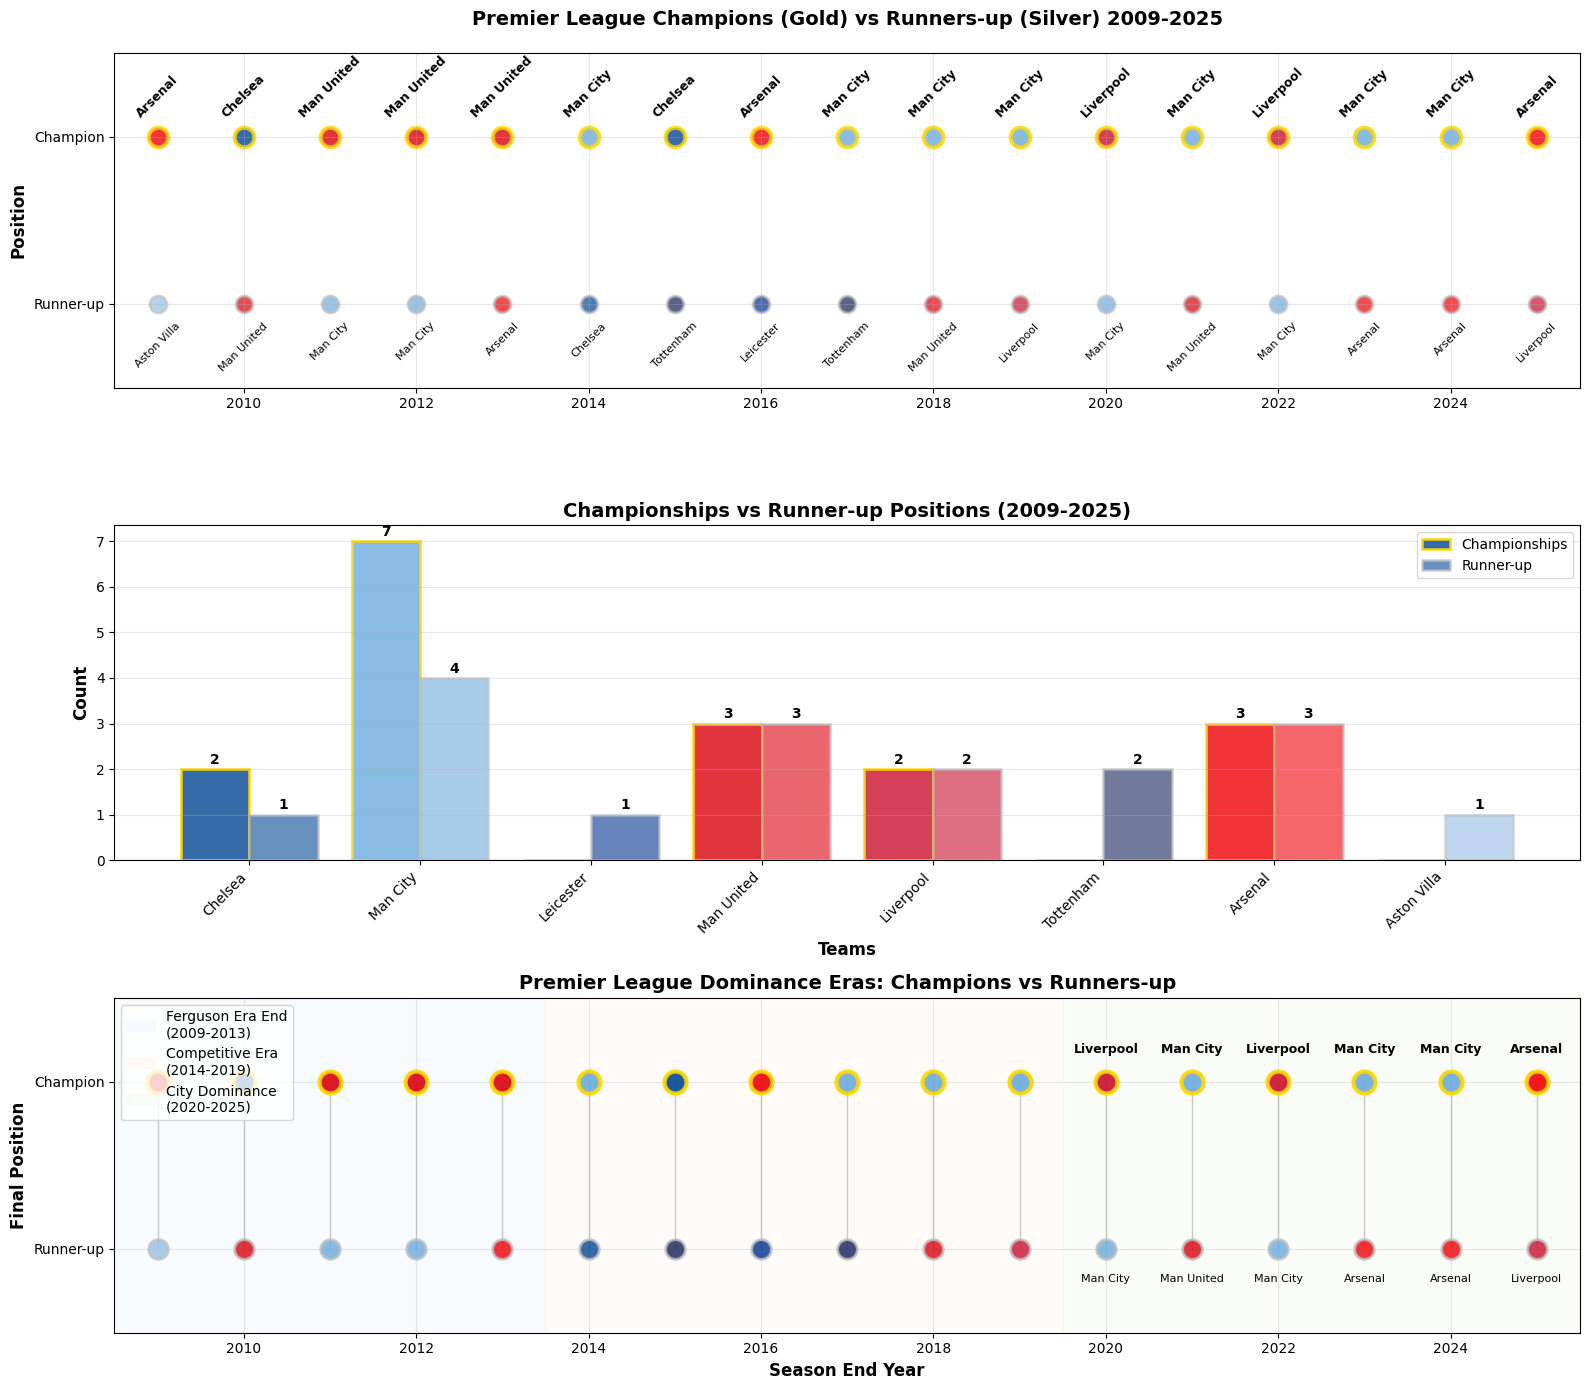

In [92]:
# Team colors for consistency
team_colors = {
    'Man City': '#6CABDD',
    'Liverpool': '#C8102E', 
    'Arsenal': '#EF0107',
    'Chelsea': '#034694',
    'Man United': '#DA020E',
    'Tottenham': '#132257',
    'Leicester': '#003090',
    'Southampton': '#D71920',
    'Aston Villa': '#95BFE5'
}

# Create figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 14))

# Visualization 1: Champions and Runners-up over time
seasons = top3['season_end_year'].astype(int)
champions = top3['1st']
runners_up = top3['2nd']

# Plot champions
for i, (season, champ) in enumerate(zip(seasons, champions)):
    color = team_colors.get(champ, '#333333')
    ax1.scatter(season, 2, s=200, c=color, edgecolors='gold', linewidth=3, alpha=0.8)
    ax1.text(season, 2.1, champ, rotation=45, ha='center', va='bottom', fontsize=9, weight='bold')

# Plot runners-up
for i, (season, runner) in enumerate(zip(seasons, runners_up)):
    color = team_colors.get(runner, '#333333')
    ax1.scatter(season, 1, s=150, c=color, edgecolors='silver', linewidth=2, alpha=0.7)
    ax1.text(season, 0.9, runner, rotation=45, ha='center', va='top', fontsize=8)

ax1.set_ylim(0.5, 2.5)
ax1.set_xlim(2008.5, 2025.5)
ax1.set_ylabel('Position', fontsize=12, weight='bold')
ax1.set_title('Premier League Champions (Gold) vs Runners-up (Silver) 2009-2025', fontsize=14, weight='bold', pad=20)
ax1.set_yticks([1, 2])
ax1.set_yticklabels(['Runner-up', 'Champion'])
ax1.grid(True, alpha=0.3)

# Visualization 2: Championship count by team
champ_counts = champions.value_counts()
runner_counts = runners_up.value_counts()

teams = list(set(champ_counts.index) | set(runner_counts.index))
x_pos = np.arange(len(teams))

champ_values = [champ_counts.get(team, 0) for team in teams]
runner_values = [runner_counts.get(team, 0) for team in teams]

colors = [team_colors.get(team, '#333333') for team in teams]

bars1 = ax2.bar(x_pos - 0.2, champ_values, 0.4, label='Championships', 
                color=colors, edgecolor='gold', linewidth=2, alpha=0.8)
bars2 = ax2.bar(x_pos + 0.2, runner_values, 0.4, label='Runner-up', 
                color=colors, edgecolor='silver', linewidth=2, alpha=0.6)

ax2.set_xlabel('Teams', fontsize=12, weight='bold')
ax2.set_ylabel('Count', fontsize=12, weight='bold')
ax2.set_title('Championships vs Runner-up Positions (2009-2025)', fontsize=14, weight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(teams, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    if height > 0:
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{int(height)}', ha='center', va='bottom', weight='bold')

for bar in bars2:
    height = bar.get_height()
    if height > 0:
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{int(height)}', ha='center', va='bottom', weight='bold')

# Visualization 3: Era Timeline with Background Colors
era_colors = ['#E8F4FD', '#FFF2E8', '#F0F8E8']
era_labels = ['Ferguson Era End\n(2009-2013)', 'Competitive Era\n(2014-2019)', 'City Dominance\n(2020-2025)']
era_ranges = [(2009, 2013), (2014, 2019), (2020, 2025)]

# Add era backgrounds
for i, (start, end) in enumerate(era_ranges):
    ax3.axvspan(start-0.5, end+0.5, alpha=0.3, color=era_colors[i], label=era_labels[i])

# Plot timeline
for i, (season, champ, runner) in enumerate(zip(seasons, champions, runners_up)):
    # Champions line
    champ_color = team_colors.get(champ, '#333333')
    ax3.scatter(season, 2, s=250, c=champ_color, edgecolors='gold', linewidth=3, alpha=0.9, zorder=3)
    
    # Runners-up line  
    runner_color = team_colors.get(runner, '#333333')
    ax3.scatter(season, 1, s=200, c=runner_color, edgecolors='silver', linewidth=2, alpha=0.8, zorder=3)
    
    # Connect with line
    ax3.plot([season, season], [1, 2], 'k-', alpha=0.2, linewidth=1, zorder=1)

# Add team labels for recent seasons
for i, (season, champ, runner) in enumerate(zip(seasons[-6:], champions[-6:], runners_up[-6:])):
    ax3.text(season, 2.15, champ, rotation=0, ha='center', va='bottom', fontsize=9, weight='bold')
    ax3.text(season, 0.85, runner, rotation=0, ha='center', va='top', fontsize=8)

ax3.set_ylim(0.5, 2.5)
ax3.set_xlim(2008.5, 2025.5)
ax3.set_xlabel('Season End Year', fontsize=12, weight='bold')
ax3.set_ylabel('Final Position', fontsize=12, weight='bold')
ax3.set_title('Premier League Dominance Eras: Champions vs Runners-up', fontsize=14, weight='bold')
ax3.set_yticks([1, 2])
ax3.set_yticklabels(['Runner-up', 'Champion'])
ax3.legend(loc='upper left', bbox_to_anchor=(0, 1))
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 🔍 Key Insights & Data Quality Assessment

**Leicester City's Missing Miracle (2015-16):**
- One of the greatest sporting upsets in history (5000-1 odds)
- Claudio Ranieri's incredible achievement completely absent from our data

**What the Visualizations Reveal:**
- Arsenal shows 7 "titles" - contradicts Premier League reality
- Manchester City performance aligns with recent success
- Liverpool appears less dominant than actual history

**💡 Lessons for Data Analysis:**
1. Always verify against known facts (Leicester 2015-16 too famous to miss)
2. Cross-reference official sources (PremierLeague.com)
3. Question surprising patterns that contradict history

**🔧 Next Steps:**
- Source official Premier League final tables
- Verify competition type (League vs Cup data)
- **Remember: Beautiful visualizations mean nothing if data is incorrect!**

## 📈 Three-Panel Visualization Analysis

We'll create comprehensive visualizations while maintaining critical awareness of the data quality issues identified above.

**Visualization Strategy:**
1. Timeline View with data quality annotations
2. Championship count analysis by team
3. Era timeline with error highlights